# Baseline Model for Crop Yield Estimation and Explaining the Relevant Factors for Model Decisions
The goal in this hackaton is to use the knowledge about explainable AI gathered in the ML4Earth xAI workshop to build machine learning model for yield prediction and to use explainable machine learning to identify the relevant factors and discover the impact of the extreme weather events for crop yield prediction [1]. Crop yield estimation is extremely important for ensuring food security in terms of the ever increasing extreme weather events [2]. Therefore, having an accurate model for yield prediction and at the same time being able to explain the relevant factors which drive the model inference is essential for designing efficient agricultural policies which can help to mitigate the food security challenges.

In this notebook, we provide an example of how to train a baseline random forest model and to use the SHAP method [3] to understand the driving factors for the model predictions.

First, we import the libraries necessary for bulding the random forest model and the explainability analysis.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import json

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

import shap

Next, we define util functions which allow us to preprocess the crop yield dataset provided in [3]. The central function is the **load_features_and_yield** function which reads the county features, and the corresponding groundtruth yield values.

In [2]:
ROOT_DATA_DIR = "dataset/composite_npy"
COUNTY_FEATURE_NAMES = ["RED", "NIR", "BLUE", "GREEN", "NIR2", "SWIR1", "SWIR2", "TEMP_MIN", "TEMP_MAX", "PRCP", "HEATWAVE INDEX", "DROUGHT INDEX", "NDVI", "EVI", "NDWI"]
NUM_FEATURES_PER_DATE = len(COUNTY_FEATURE_NAMES)

# "year" should be the integer year number (2000-2021)
# The function will return a list of required dates
def get_observation_acquisition_dates(year):
    # read a certain column before the 46th row
    df = pd.read_excel(io=os.path.join(ROOT_DATA_DIR, 'MODIS dates.xlsx'), usecols=[year - 2000], nrows=46)
    dates = df[year].values.tolist()
    return dates

def get_feature_names(dates):
    feature_names = []
    for date in dates:
        for county_feature in COUNTY_FEATURE_NAMES:
            feature_name = '{}_{}'.format(date, county_feature)
            feature_names.append(feature_name)
    
    return feature_names

def load_features_and_yield(target_year):
    #read the crop yield values from the json file
    with open(os.path.join(ROOT_DATA_DIR, 'labels.json')) as f:
        crop_yield_per_county = json.load(f)
    
    counties_features = []
    counties_yield = []
    
    #read the parcel features and the corresponding yields
    for county_features_file in os.listdir(ROOT_DATA_DIR):
        if county_features_file.startswith(str(target_year)):
            county_id = county_features_file.split('.')[0].split('_')[1]
            county_id_key = '{}_{}'.format(county_id, target_year)
            if county_id_key in crop_yield_per_county:
                county_yield = float(crop_yield_per_county[county_id_key])
                counties_yield.append(county_yield)
                county_features_file_path = os.path.join(ROOT_DATA_DIR, county_features_file)
                county_features = np.load(county_features_file_path)
                counties_features.append(county_features.flatten())
    
    
    
    #scale all features in range [0, 1]
    counties_features = np.array(counties_features)
    scaler = MinMaxScaler()
    scaler.fit(counties_features)
    counties_features = scaler.transform(counties_features)
    
    #convert the features to pandas dataframe
    observation_acquisition_dates = get_observation_acquisition_dates(target_year)
    feature_names = get_feature_names(observation_acquisition_dates)
    counties_features = pd.DataFrame(counties_features, columns = feature_names)
    
    counties_yield = np.array(counties_yield)
    return counties_features, counties_yield

def get_abs_feature_importance_over_time(feature_suffix, shap_values, feature_names):
    feature_indices = np.array([feature_names.index(feature) for feature in feature_names if feature.endswith(feature_suffix)])
    feature_dates = [feature_names[idx].split('_')[0] for idx in feature_indices]
    feature_importance_over_time = np.take(shap_values.values, feature_indices, 1)
    
    feature_importance_over_time = pd.DataFrame(np.abs(feature_importance_over_time), columns=feature_dates)
    feature_importance_over_time = pd.melt(feature_importance_over_time, var_name="Date", value_name="SHAP feature importance")
    feature_importance_over_time["Feature"] = feature_suffix
    feature_importance_over_time['Date'] =  pd.to_datetime(feature_importance_over_time['Date'], format='%Y%m%d')
    return feature_importance_over_time

def get_abs_features_importances_over_time(shap_values, feature_names):
    all_features_importances_over_time = []
    
    for feature_suffix in COUNTY_FEATURE_NAMES:
        all_features_importances_over_time.append(get_abs_feature_importance_over_time(feature_suffix, shap_values, feature_names))
    
    return pd.concat(all_features_importances_over_time)

## Loading the features and the crop yield dataset for 2021
In our example, we train and predict the yield for 2021 for counties of the corn crop type. We load the dataset for 2021 by utilizing the above-defined **load_features_and_yield** function.

In [3]:
#load the dataset
counties_features, counties_yield = load_features_and_yield(2021)
feature_names = counties_features.columns.values.tolist()

## Random Forest Model Training
For training the random forest model, we randomly split the counties to 80% in the training set and 20% in the test set. Afterwards, we use the implementation from the scikit-learn library to train a regression random forest model for yield prediction and we output the score of our model on the test set.

In [4]:
#train and test the random forest model based on the data acquired in 2021
counties_features_train, counties_features_test, counties_yield_train, counties_yield_test = train_test_split(counties_features, counties_yield, test_size=0.2, random_state=42)
random_forest_regressor = RandomForestRegressor(n_estimators=50)
random_forest_regressor.fit(counties_features_train, counties_yield_train)
r2_score = random_forest_regressor.score(counties_features_test, counties_yield_test)
print("R^2 score in the test set is %0.2f" % (r2_score))

R^2 score in the test set is 0.37


To estimate the feature importance of different input variables for the trained random forest model, we use the SHAP implementation provided in the SHAP library [5]. The feature importances are computed by first initializing the **TreeExplainer** class with the trained random and afterwards the **explainer** method is called with the feature representation of the test set which returns the SHAP feature importances for every feature and data point in the test set. The below figure shows the absolute average contribution of each variable in a time point to the difference between the model prediction and the average of the predictions of the random forest model.

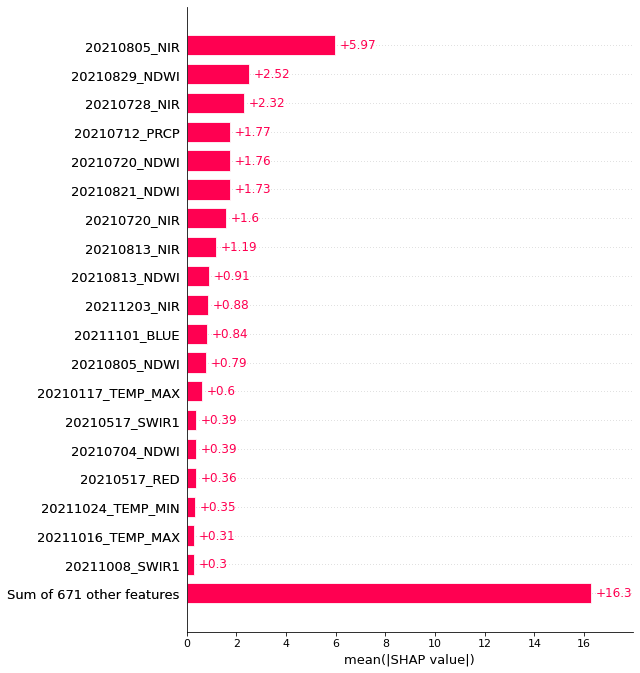

In [5]:
explainer = shap.TreeExplainer(random_forest_regressor)
shap_values = explainer(counties_features_test)
shap.plots.bar(shap_values, max_display=20)

Although the default barplot visualization from the SHAP library gives us indication the NIR band and the EWI derived feature have high importance in August, it still doesn't allow for clear visualization and interpretation of the variable and temporal importance of the trained model. Therefore, in the next step, we implement and use the **get_abs_features_importances_over_time** function which summarizes the importance for every feature and date into a single dataframe. Next, we use this dataframe to plot the evolvement of the SHAP values over time for every of the 15 input features to the model.

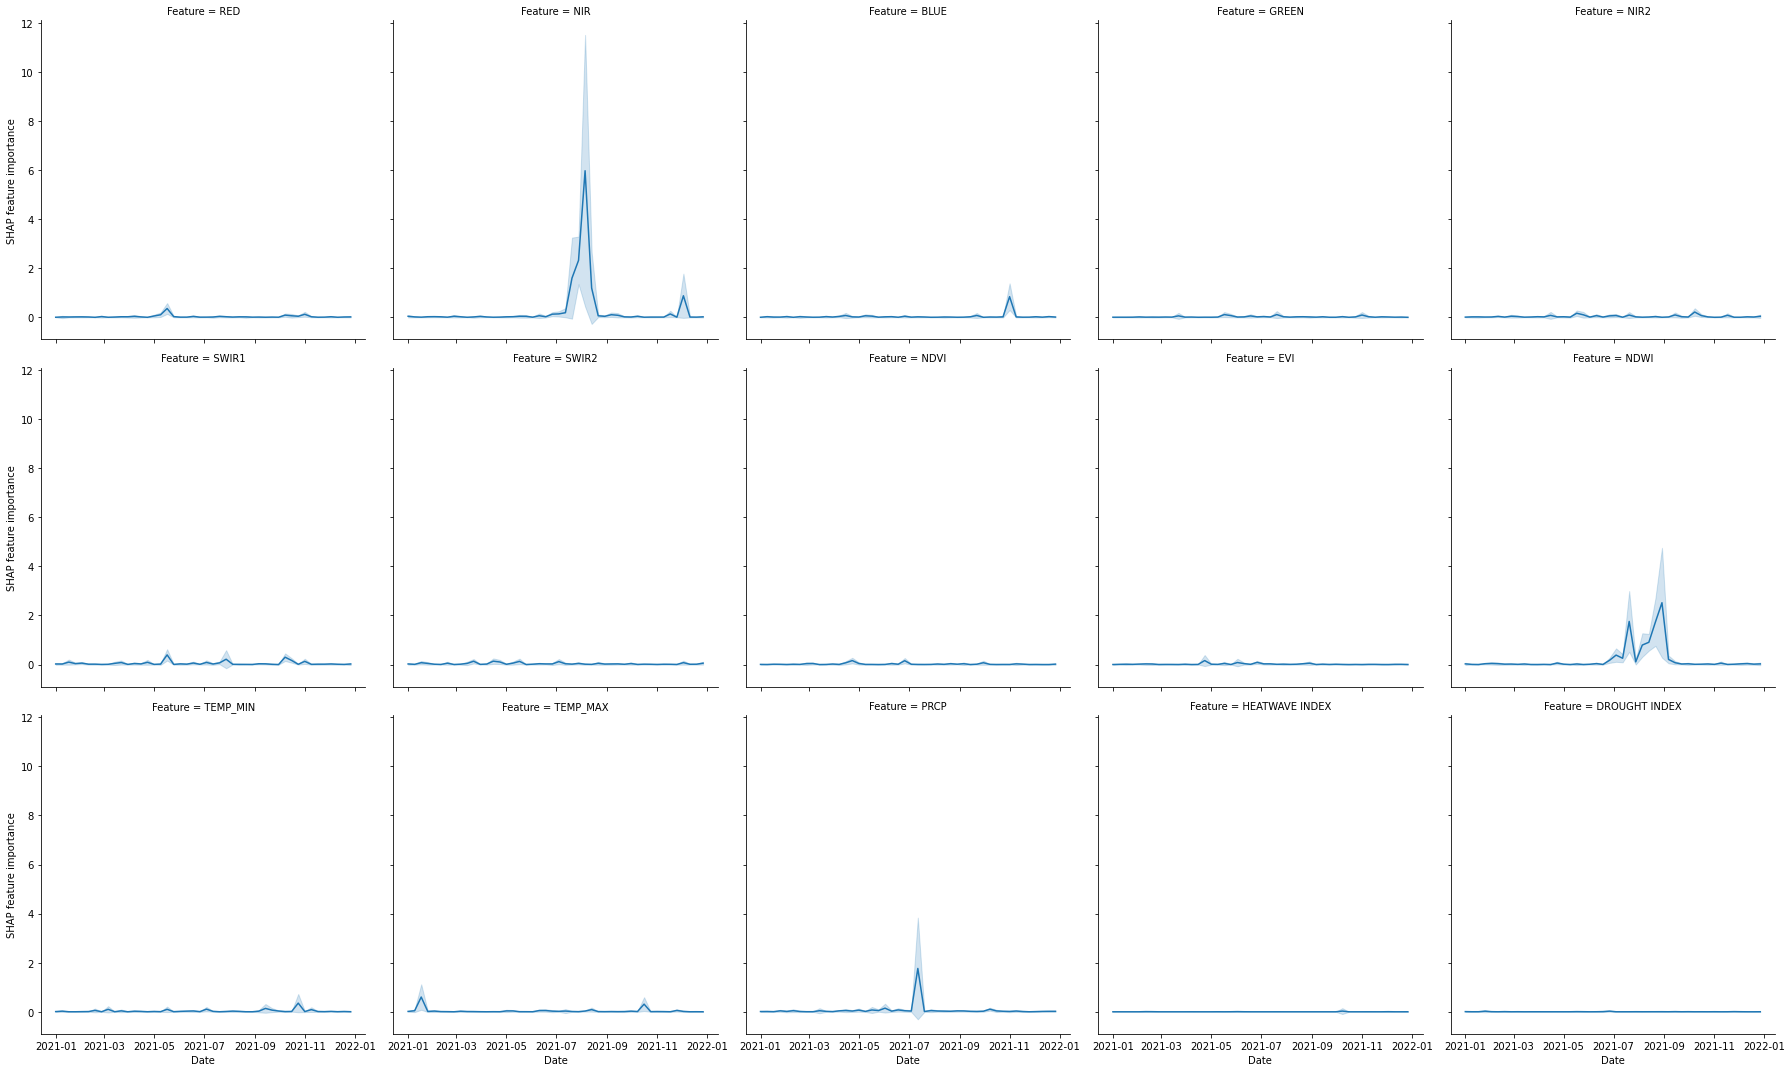

In [6]:
abs_features_importances_over_time = get_abs_features_importances_over_time(shap_values, feature_names)
g = sns.relplot(
    data=abs_features_importances_over_time,
    x="Date", y="SHAP feature importance",
    col="Feature",kind="line",
    ci="sd", col_order=["RED", "NIR", "BLUE", "GREEN", "NIR2", "SWIR1", "SWIR2", "NDVI", "EVI", "NDWI", "TEMP_MIN", "TEMP_MAX", "PRCP", "HEATWAVE INDEX", "DROUGHT INDEX"],
    col_wrap=5, height=5, aspect=1)

The plot above shows us that in terms of variable importance, the factors that most significantly impact the yield prediction are the NIR infrared and the NDWI index. The weather related variables have SHAP feature importances close to zero except for the precipitation. Additionally, these plot indicates that the heatwawe and drought index variable do not influence the model decisions.
On the other hand, in terms of temporal importance, the observations in the late vegetation season (end of summer) are valuable to the model. The exception is the precipitation variable whose relevant observations occur near July.

This notebook presented a simple framework which trains a baseline random forest model for crop yield prediction and uses the SHAP method to understand the relevant factors for the model inference. In this hackaton, we are looking forward to the application and development of more novel machine learning and deep learning methods for yield prediction as well as to xAI approaches that extract more useful insights for the inner workings of the model that could be of use to the different stakeholders. A possible starting directions could be the following:
- The impact of the extreme weather events on yield prediction.
- Counterfactual explanations. Example: Would the yield have been bigger if the temperature was lower.
- Early yield prediction: Development of methods that can accurately predict the yield by using only the observations acquired in early vegetation season. Additionally, in order to take preventive measures, it would be interesting to understand which factor impact the low/high yield to be discovered early in the season.
- The presented approach used single year for training and testing the model. A more realistic scenario and an interesting research direction to explore would be to evaluate the model performance on future years when it is trained on the past years.

# References:
[1] https://ml4earth.devpost.com/ <br>
[2] Wolanin, Aleksandra, et al. "Estimating and understanding crop yields with explainable deep learning in the Indian Wheat Belt." Environmental research letters 15.2 (2020): 024019. <br>
[3] Lundberg, Scott M., and Su-In Lee. "A unified approach to interpreting model predictions." Advances in neural information processing systems 30 (2017). <br>
[4] https://syncandshare.lrz.de/getlink/fiUh1RofUeMbugsSGD19QX/ <br>
[5] https://shap.readthedocs.io/en/latest/index.html <br>